In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from konlpy.tag import Okt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
import pickle
import re
import os
import json

In [6]:
from tensorflow.keras.models import load_model

In [7]:
from tqdm import tqdm

In [8]:
okt = Okt()

In [10]:
result2 = pd.read_csv('community_add_market2.csv')

In [13]:
result2.head(2)

,닉네임,날짜,내용,종목,내용_토큰,label,시장
0,GROK,2025-01-11T22:59:18+09:00,- 디자인 변화: S25 울트라는 기존의 각진 디자인에서 둥근 모서리로 변경되었으며...,005930,디자인 변화 울트라 기존 디자인 에서 둥글다 모서리 변경 되어다 카메라 모듈 디자인...,1,KOSPI
1,공감아,2025-01-11T22:47:22+09:00,7만원 8만원에 물려있는게 대부분이라 7만원까지 혹여 올라도 물려있던분들은 원금 회...,005930,만원 만원 물리다 대부분 이라 만원 까지 오르다 물리다 분들 원금 회복 다시 매도 ...,-2,KOSPI


In [14]:
result2['label'].value_counts()

label
-2    46574
 0    17397
 1    13676
Name: count, dtype: int64

In [15]:
result2 = result2.drop_duplicates(subset=['내용_토큰'])

In [16]:
result2['label'].value_counts()

label
-2    37840
 0    16149
 1    12916
Name: count, dtype: int64

In [31]:
# label 열의 값 개수 세기
label_counts = result2['label'].value_counts()

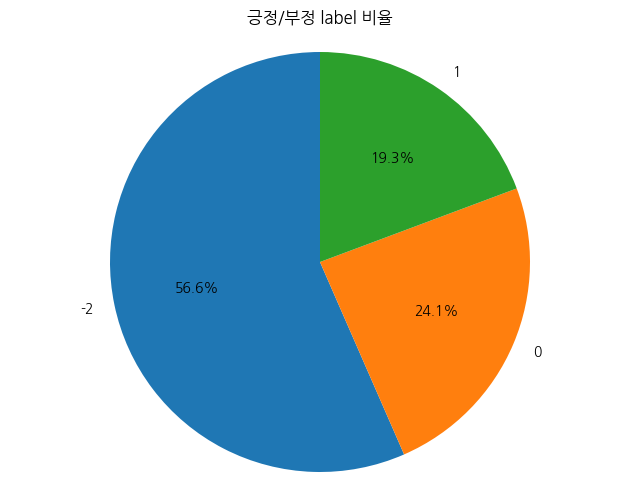

In [32]:
# 파이차트 그리기
plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('긍정/부정 label 비율')
plt.axis('equal')  # 원형으로 만들기
plt.show()

In [17]:
# 언더 샘플링

sample_data_positive = result2[result2['label'] == 1].sample(12916)
sample_data_negative = result2[result2['label'] == 0].sample(12916)

total_data = pd.concat([sample_data_positive,sample_data_negative])

In [20]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25832 entries, 47043 to 59391
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   닉네임     25832 non-null  object
 1   날짜      25832 non-null  object
 2   내용      25832 non-null  object
 3   종목      25832 non-null  object
 4   내용_토큰   25832 non-null  object
 5   label   25832 non-null  int64 
 6   시장      25832 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.6+ MB


In [21]:
total_data['내용'].nunique()

25832

In [22]:
# 학습 데이터와, 테스트 데이터를 구분
train_data, test_data = train_test_split(total_data, test_size=0.25, random_state=2025)

<Axes: xlabel='label'>

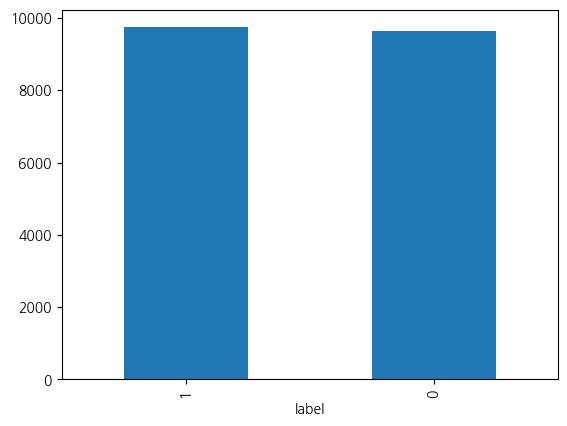

In [38]:
train_data['label'].value_counts().plot(kind = 'bar')

In [23]:
# 내용 열과 label 열의 중복을 제외한 값의 개수
train_data['내용'].nunique(), train_data['label'].nunique()

(19374, 2)

In [24]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 19374


In [25]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0   9634
1      1   9740


In [26]:
print(train_data.isnull().values.any())

False


In [43]:
print(train_data.isnull().sum())

닉네임      0
날짜       0
내용       0
종목       0
내용_토큰    0
label    0
시장       0
dtype: int64


In [27]:
# 한글과 공백을 제외하고 모두 제거
train_data['내용'] = train_data['내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
# train_data[:5]
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19374 entries, 46839 to 5758
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   닉네임     19374 non-null  object
 1   날짜      19374 non-null  object
 2   내용      19374 non-null  object
 3   종목      19374 non-null  object
 4   내용_토큰   19374 non-null  object
 5   label   19374 non-null  int64 
 6   시장      19374 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.2+ MB


In [ ]:
# train_data['내용'] = train_data['내용'].str.replace('^ +', "", regex=True) # white space 데이터를 empty value로 변경
# train_data['내용'] = train_data['내용'].replace('', np.nan)
# print(train_data.isnull().sum())

닉네임      0
날짜       0
내용       0
종목       0
내용_토큰    0
label    0
시장       0
dtype: int64


In [29]:
test_data.drop_duplicates(subset = ['내용'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['내용'] = test_data['내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['내용'] = test_data['내용'].str.replace('^ +', "", regex=True) # 공백은 empty 값으로 변경
test_data['내용'] = test_data['내용'].replace('', np.nan) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))


전처리 후 테스트용 샘플의 개수 : 6458


In [31]:
stopwords = ['의','가','이','은','들','는',
             '좀','잘','걍','과','도','를',
             '으로','자','에','와','한','하다',
             '을','있다','되다','보다','로','이다',
             '요','일','안','것','주','다','년','속',
             '합', '니', '딘','저', '두', '적','고',
             '나', '인', '멱', '기'
             ]

In [32]:
X_train = []
for sentence in tqdm(train_data['내용']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)


100%|██████████| 19374/19374 [00:57<00:00, 338.67it/s]


In [33]:
print(X_train[:3])

[['기', '관외', '인', '멱', '많다', '크다', '먹다', '이제', '슬슬', '파다', '시작', '그래서', '개미', '만', '죽다'], ['아래', '개', '계좌', '에서', '모으다', '현재', '각', '수익', '중', '인데', '나스닥', '밉다', '배당금', '세', '개다', '조정', '오다', '같다', '번', '싹', '파다', '밉다', '배당', '빼다', '나스닥', '밉다', '배당금', '미국', '채년', '선물'], ['아', '진짜', '모', '냐', '단', '타', '안치', '믿다']]


In [34]:
X_test = []
for sentence in tqdm(test_data['내용']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)


  0%|          | 0/6458 [00:00<?, ?it/s]

100%|██████████| 6458/6458 [00:18<00:00, 348.80it/s]


In [35]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [36]:
print(tokenizer.word_index)


{'없다': 1, '만': 2, '에서': 3, '좋다': 4, '원': 5, '아니다': 6, '오르다': 7, '주가': 8, '떨어지다': 9, '주식': 10, '투자': 11, '더': 12, '같다': 13, '가다': 14, '오늘': 15, '오다': 16, '매수': 17, '까지': 18, '상승': 19, '인': 20, '때': 21, '하고': 22, '받다': 23, '국장': 24, '않다': 25, '수': 26, '성': 27, '생각': 28, '배당': 29, '들다': 30, '만원': 31, '시장': 32, '아': 33, '못': 34, '내': 35, '진짜': 36, '월': 37, '하': 38, '지금': 39, '네': 40, '중': 41, '나오다': 42, '전': 43, '거': 44, '돈': 45, '많다': 46, '미국': 47, '하락': 48, '수익': 49, '분': 50, '왜': 51, '다시': 52, '지': 53, '제': 54, 'ㅋㅋ': 55, '사람': 56, '크다': 57, '인데': 58, '실적': 59, '회사': 60, '성장': 61, '그': 62, '믿다': 63, '시': 64, '기업': 65, '너무': 66, '먹다': 67, '게': 68, '주주': 69, '알다': 70, '면': 71, '또': 72, '그냥': 73, '매출': 74, '매도': 75, '많이': 76, '말': 77, '그렇다': 78, '기': 79, '대': 80, '탈출': 81, '목표': 82, '올라가다': 83, '점': 84, '삼성': 85, '이제': 86, '부터': 87, '등': 88, '억': 89, '장': 90, '사다': 91, '기술': 92, '미장': 93, '주다': 94, '이번': 95, '물': 96, '계속': 97, '개': 98, 'ㅠㅠ': 99, '기다리다': 100, '라': 101, '및': 102, '자다': 103, '

In [37]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# key,value : 단어, 빈도수
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 등장 빈도수 < threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 17924
등장 빈도가 1번 이하인 희귀 단어의 수: 7665
단어 집합에서 희귀 단어의 비율: 42.76389198839545
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.4709386665635096


In [38]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 10260


In [39]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [40]:
print(X_train[:3])


[[79, 7804, 20, 46, 57, 67, 86, 1202, 124, 172, 957, 146, 2, 311], [652, 98, 346, 3, 256, 125, 877, 49, 41, 58, 653, 465, 223, 260, 777, 282, 16, 13, 320, 1361, 124, 465, 29, 252, 653, 465, 223, 47, 922], [33, 36, 886, 366, 327, 292, 5638, 63]]


In [41]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [42]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [43]:
# 빈 샘플들을 제거
X_train = np.array(X_train, dtype=object)
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))


19366
19366


In [44]:
print('내용의 최대 길이 :',max(len(review) for review in X_train))
print('내용의 평균 길이 :',sum(map(len, X_train))/len(X_train))

내용의 최대 길이 : 268
내용의 평균 길이 : 15.622276154084478


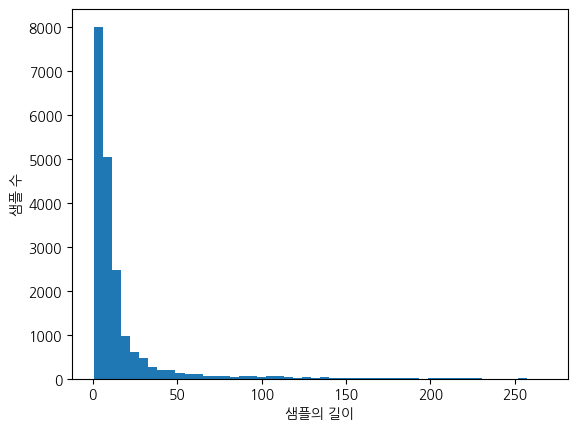

In [45]:

plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('샘플의 길이')
plt.ylabel('샘플 수')
plt.show()


In [46]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))
  
max_len = 100
below_threshold_len(max_len, X_train)


전체 샘플 중 길이가 100 이하인 샘플의 비율: 97.61953939894661


In [65]:
max_len = 100
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 100 이하인 샘플의 비율: 97.58855726531034


In [64]:
max_len = 70
below_threshold_len(max_len, X_train)


전체 샘플 중 길이가 70 이하인 샘플의 비율: 96.04461427243622


In [47]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [48]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=4, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/4
242/243 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - acc: 0.7014 - loss: 0.5701
Epoch 1: val_acc improved from -inf to 0.84047, saving model to best_model.keras
243/243 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - acc: 0.7023 - loss: 0.5690 - val_acc: 0.8405 - val_loss: 0.3637
Epoch 2/4
242/243 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - acc: 0.9322 - loss: 0.2003
Epoch 2: val_acc improved from 0.84047 to 0.93598, saving model to best_model.keras
243/243 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - acc: 0.9323 - loss: 0.1999 - val_acc: 0.9360 - val_loss: 0.1700
Epoch 3/4
242/243 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - acc: 0.9768 - loss: 0.0697
Epoch 3: val_acc improved from 0.93598 to 0.95973, saving model to best_model.keras
243/243 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - acc: 0.9768 - loss: 0.0697 - val_acc: 0.9597 - val_loss: 0.1298
Epoch 4/4
242/243 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - acc: 0.9895 - loss: 0.0385
Epoch 4: val_acc improved from 0.95973 to 0.96051, saving model to best_model.keras
243/243 ━━━━━━━━

In [49]:
loaded_model = load_model('best_model.keras')
test_loss, test_acc= loaded_model.evaluate(X_test, y_test)
print('\n 테스트 손실 : %.4f' % test_loss)
print('\n 테스트 정확도: %.4f' % test_acc)

202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - acc: 0.9594 - loss: 0.1169

 테스트 손실 : 0.1178

 테스트 정확도: 0.9616


In [50]:
# 저장할 디렉토리 설정
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)

# 1. 모델 저장
model.save(os.path.join(save_dir, 'best_model.keras'))

# 2. 토크나이저 저장
with open(os.path.join(save_dir, 'tokenizer.pkl'), 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 3. 학습 정보 저장
with open(os.path.join(save_dir, 'history.pkl'), 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 4. 데이터 전처리 정보 저장
preprocessing_info = {
    'stopwords': stopwords,
    'max_len': max_len,
    'vocab_size': vocab_size
}

with open(os.path.join(save_dir, 'preprocessing_info.json'), 'w') as json_file:
    json.dump(preprocessing_info, json_file)

print("모델, 토크나이저, 학습 정보, 데이터 전처리 정보가 저장되었습니다.")

모델, 토크나이저, 학습 정보, 데이터 전처리 정보가 저장되었습니다.


In [ ]:
# 모델 로드
loaded_model = load_model(os.path.join(save_dir, 'best_model.keras'))

# 토크나이저 로드
with open(os.path.join(save_dir, 'tokenizer.pkl'), 'rb') as handle:
    tokenizer = pickle.load(handle)

# 학습 정보 로드
with open(os.path.join(save_dir, 'history.pkl'), 'rb') as handle:
    loaded_history = pickle.load(handle)

# 데이터 전처리 정보 로드
with open(os.path.join(save_dir, 'preprocessing_info.json'), 'r') as json_file:
    loaded_preprocessing_info = json.load(json_file)

In [ ]:
# 손실률 그래프
plt.figure(figsize=(12, 5))

# 오버피팅 발생 에포크 (직접 확인)
overfitting_epoch_loss = 4 

# 손실률
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='훈련 손실')
plt.plot(history.history['val_loss'], label='검증 손실')
plt.axvline(x=overfitting_epoch_loss, color='r', linestyle='--')
plt.title('손실률 변화')
plt.xlabel('에포크')
plt.ylabel('손실')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='훈련 정확도')
plt.plot(history.history['val_acc'], label='검증 정확도')
plt.axvline(x=overfitting_epoch_loss, color='r', linestyle='--')
plt.title('정확도 변화')
plt.xlabel('에포크')
plt.ylabel('정확도')
plt.legend()

plt.tight_layout()
plt.show()

In [52]:
sample_sentences = [
    "이번 분기 실적이 예상보다 나빠서 주가가 크게 하락할 것 같아요.",               # 부정
    "이 기업의 경영진이 믿을 수 없어서 투자하기가 망설여집니다.",                   # 부정
    "최근 뉴스에서 부정적인 이슈가 많아 주식이 불안정합니다.",                      # 부정
    "주가가 계속 하락세인데, 더 이상 보유할 이유가 없네요.",                        # 부정
    "이 회사의 제품이 소비자에게 외면받고 있어서 걱정입니다.",                      # 부정
    "전문가들이 이 종목을 추천하지 않아서 매도해야 할 것 같아요.",                  # 부정
    "지속적인 적자에 시달리고 있어서 회복이 힘들 것 같습니다.",                     # 부정  
    "주식 시장 전반이 불안정한데 이 종목은 더 위험해 보입니다.",                    # 부정
    "배당금이 줄어들었고, 앞으로도 회복 가능성이 낮아 보입니다.",                   # 부정
    "외국인 투자자들이 빠져나가고 있어 주가에 부정적인 영향을 미칠 것 같습니다.",    # 부정
    "이 회사는 실적이 계속 나빠지고 있어요. 이제는 매도해야 할 때인 것 같습니다.",   # 부정
    "주가가 너무 비싸요. 조정이 올 것 같아서 걱정입니다.",                          # 부정
    "이번 분기 실적이 예상보다 나빠서 주가가 크게 하락할 것 같아요.",               # 부정
    "이 기업의 경영진이 믿을 수 없어서 투자하기가 망설여집니다.",                   # 부정
    "최근 뉴스에서 부정적인 이슈가 많아 주식이 불안정합니다.",                      # 부정
    "주가가 계속 하락세인데, 더 이상 보유할 이유가 없네요.",                        # 부정
    "이 회사의 제품이 소비자에게 외면받고 있어서 걱정입니다.",                      # 부정
    "전문가들이 이 종목을 추천하지 않아서 매도해야 할 것 같아요.",                  # 부정
    "지속적인 적자에 시달리고 있어서 회복이 힘들 것 같습니다.",                     # 부정
    "주식 시장 전반이 불안정한데 이 종목은 더 위험해 보입니다.",                    # 부정
    "배당금이 줄어들었고, 앞으로도 회복 가능성이 낮아 보입니다.",                   # 부정
    "외국인 투자자들이 빠져나가고 있어 주가에 부정적인 영향을 미칠 것 같습니다.",    # 부정
    "이 회사의 성장 가능성이 정말 기대돼요! 앞으로 주가가 오를 것 같습니다.",       # 긍정
    "이번 분기 실적이 예상보다 좋았어요. 강력한 매수 추천합니다!",                  # 긍정
    "이 주식은 장기 투자로 정말 좋은 선택입니다. 믿고 투자하세요!",                 # 긍정
    "이번 분기 실적이 기대 이상이라 주가가 상승할 것 같아요.",                      # 긍정
    "이 회사의 기술력이 탁월해서 앞으로의 성장 가능성이 큽니다.",                   # 긍정
    "주식이 오랜만에 반등해서 너무 기쁘네요!",                                      # 긍정
    "상장 이후 꾸준히 오르는 모습에 투자하기 잘했다는 생각이 들어요.",              # 긍정
    "외국인 투자자들이 많이 들어오고 있어서 긍정적인 신호입니다.",                  # 긍정
    "배당금이 증가해서 안정적인 투자처로 보입니다.",                                # 긍정
    "이 기업의 새로운 제품이 시장에서 좋은 반응을 얻고 있습니다.",                  # 긍정
    "전문가들이 추천하는 종목이라 믿고 투자하고 있습니다.",                         # 긍정
    "최근 긍정적인 뉴스가 많아 주가가 더 오를 것 같아요.",                          # 긍정
    "이 회사의 비전이 확실해서 장기 투자로 괜찮다고 생각해요."                      # 긍정
    "이 회사는 지속적으로 좋은 실적을 내고 있어서 앞으로도 기대가 됩니다.",          # 긍정
    "최근 주가 상승세가 눈에 띄어 투자자들의 관심이 집중되고 있습니다.",             # 긍정
    "이 기업의 혁신적인 기술이 시장에서 큰 주목을 받고 있습니다.",                   # 긍정
    "배당금이 꾸준히 증가하고 있어 안정적인 투자처로 손색이 없습니다.",              # 긍정
    "주식이 안정적으로 오르고 있어서 마음 편하게 투자하고 있습니다.",                # 긍정
    "이 종목은 전문가들의 추천을 받으며 긍정적인 평가를 받고 있습니다.",             # 긍정
    "회사의 장기적인 비전이 확고해 투자할 가치가 충분합니다.",                       # 긍정
    "최근에 발표된 실적이 예상보다 좋았고, 이는 긍정적인 신호입니다.",               # 긍정
    "이 기업의 성장 가능성이 매우 높아 보이기 때문에 투자할 기회입니다.",             # 긍정
    "이 회사의 새로운 프로젝트가 큰 성공을 거두고 있어 앞으로의 성장에 기대가 큽니다." # 긍정
]

In [53]:
sample = pd.DataFrame(sample_sentences, columns=['문장'])
sample['실제 레이블'] = 0  # 기본값으로 0 설정
for idx, comment in enumerate(sample['문장'].values):
  if idx >= 22:  
    sample.loc[idx, '실제 레이블'] = 1  # 인덱스가 22 이상인 경우 1로 설정
  

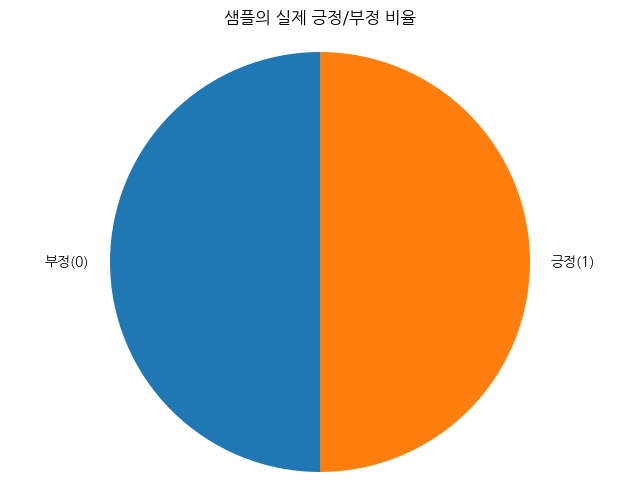

In [54]:
# 레이블 비율 계산
label_counts = sample['실제 레이블'].value_counts()

# 파이 차트 시각화
plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=['부정(0)', '긍정(1)'], startangle=90)
plt.title('샘플의 실제 긍정/부정 비율')
plt.axis('equal')
plt.show()

In [55]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', new_sentence) # 특수 문자 제거
  new_sentence = okt.morphs(new_sentence, stem=True)             # 토큰화
  encoded = tokenizer.texts_to_sequences([new_sentence])         # 정수 인코딩 
  pad_new = pad_sequences(encoded, maxlen=max_len)               # 패딩 
  predicted_value = loaded_model.predict(pad_new)                # 예측
  
  score = float(predicted_value[0])
  return score  

# 예측 결과를 저장할 리스트
results = []

# 각 샘플 문장에 대해 예측 수행
for idx, sentence in enumerate(sample['문장'].values):
  # 예측 수행
  score = sentiment_predict(sentence)
  
  if score > 0.5 : 
    score_persentage =  score * 100
  else:
    score_persentage =  (1 - score) * 100
  
  # 결과 저장
  results.append({
      '문장': sentence,
      '예측 확률': score_persentage,
      '예측 레이블': 1 if score > 0.5 else 0,
      '실제 레이블': sample.loc[idx, '실제 레이블']
  })
# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

# 확률을 소수점 두 자리로 포맷하여 백분율로 변환
results_df['예측 확률'] = results_df['예측 확률'] \
                        .apply(lambda x: "{:.2f}%".format(x))
# 각 레이블에 대한 정답률 계산
accuracy_0 = (results_df[results_df['실제 레이블'] == 0]['예측 레이블'] == 0) \
              .sum() / (results_df['실제 레이블'] == 0).sum() * 100
accuracy_1 = (results_df[results_df['실제 레이블'] == 1]['예측 레이블'] == 1) \
              .sum()  / (results_df['실제 레이블'] == 1).sum() * 100
              
display(results_df)
# 정답률 출력
print('부정리뷰 정답률: {:.2f}%'.format(accuracy_0))
print('긍정리뷰 정답률: {:.2f}%'.format(accuracy_1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


C:\Users\hydrl\AppData\Local\Temp\ipykernel_8660\417387600.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(predicted_value[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

,문장,예측 확률,예측 레이블,실제 레이블
0,이번 분기 실적이 예상보다 나빠서 주가가 크게 하락할 것 같아요.,99.99%,0,0
1,이 기업의 경영진이 믿을 수 없어서 투자하기가 망설여집니다.,96.77%,0,0
2,최근 뉴스에서 부정적인 이슈가 많아 주식이 불안정합니다.,97.47%,1,0
3,"주가가 계속 하락세인데, 더 이상 보유할 이유가 없네요.",99.91%,0,0
4,이 회사의 제품이 소비자에게 외면받고 있어서 걱정입니다.,94.47%,0,0
5,전문가들이 이 종목을 추천하지 않아서 매도해야 할 것 같아요.,87.76%,0,0
6,지속적인 적자에 시달리고 있어서 회복이 힘들 것 같습니다.,100.00%,0,0
7,주식 시장 전반이 불안정한데 이 종목은 더 위험해 보입니다.,99.37%,0,0
8,"배당금이 줄어들었고, 앞으로도 회복 가능성이 낮아 보입니다.",99.97%,1,0
9,외국인 투자자들이 빠져나가고 있어 주가에 부정적인 영향을 미칠 것 같습니다.,95.16%,0,0


부정리뷰 정답률: 81.82%
긍정리뷰 정답률: 100.00%


In [56]:
df = pd.read_csv('practice_Toss_KOSPI_2025-01-18.csv')

In [57]:
df.head(1)

,닉네임,날짜,내용,종목
0,짜호룽,2025-01-18T14:10:20+09:00,배당금 받은걸로 조금씩 추매하고..,5930


In [58]:
# 실제 샘플테스트

def sentiment_predict(new_sentence):
  
  # URL 패턴 확인
  if re.search(r'http[s]?://|www\.|\.com|\.net', new_sentence):
    return None, 'advertisement'  # 광고성 내용 처리
    
  # 특수 문자와 공백 체크
  if re.match(r'^[^ㄱ-ㅎㅏ-ㅣ가-힣]+$', new_sentence.strip()):
    return None, 'empty'  # 빈 문장 처리  
    
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', new_sentence) # 특수 문자 제거
  
  if not new_sentence.strip():  # 특수 문자 제거 후 빈 문자열인지 확인
    return None, 'empty'  # 빈 문장 처리
  new_sentence = okt.morphs(new_sentence, stem=True)             # 토큰화
  encoded = tokenizer.texts_to_sequences([new_sentence])         # 정수 인코딩 
  pad_new = pad_sequences(encoded, maxlen=max_len)               # 패딩 
  predicted_value = loaded_model.predict(pad_new)                # 예측
  
  score = float(predicted_value[0])
  return score, None  

# 예측 결과를 저장할 리스트
results = []

# 각 샘플 문장에 대해 예측 수행
for idx, sentence in enumerate(df['내용'].values):
  
  # 예측 수행
  score, tag = sentiment_predict(sentence)

  if tag == 'advertisement':
      results.append({
          '문장': sentence,
          '예측 확률': None,
          '예측 레이블': 'advertisement'
      })
      continue
  elif tag == 'empty':
      results.append({
          '문장': sentence,
          '예측 확률': None,
          '예측 레이블': 'empty'
      })
      continue

  if score is not None:
      score_percentage = score * 100 if score > 0.5 else (1 - score) * 100
      results.append({
          '문장': sentence,
          '예측 확률': score_percentage,
          '예측 레이블': 1 if score > 0.5 else 0,
      })
    
# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

# 확률을 소수점 두 자리로 포맷하여 백분율로 변환
results_df['예측 확률'] = results_df['예측 확률']\
                      .apply(lambda x: "{:.2f}%".format(x) if x is not None else 'N/A')
                      
# 예측 라벨링 기반 긍정점수 계산
# 라벨이 1인 레이블의 비율 계산
total_count = len(results_df[results_df['예측 레이블'].isin([0, 1])])  # 0과 1 레이블의 수
positive_count = len(results_df[results_df['예측 레이블'] == 1])  # 라벨이 1인 경우의 수

if total_count > 0:
    positive_ratio = (positive_count / total_count) * 100
else:
    positive_ratio = 0

display(results_df)
print(f'이 종목의 긍정 점수 : {positive_ratio:.2f}% ')
# # 정답률 출력
# print('부정리뷰 정답률: {:.2f}%'.format(accuracy_0))
# print('긍정리뷰 정답률: {:.2f}%'.format(accuracy_1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


C:\Users\hydrl\AppData\Local\Temp\ipykernel_8660\3839959439.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(predicted_value[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

,문장,예측 확률,예측 레이블
0,배당금 받은걸로 조금씩 추매하고..,99.65%,1
1,https://m.site.naver.com/1AS4j,nan%,advertisement
2,망햇다,53.36%,0
3,민노총에게 구타당하고.\n보수집회에는 시비거는 이상한 경찰.\n세금을 민노총ㆍ중공에...,nan%,advertisement
4,아 묶였네 언제 오르나,71.71%,0
...,...,...,...
575,오이한번만 오이주이소,80.50%,1
576,삼전평단\n62000\n삼물평단170000\n상성그룹경영진의소액주주홀대피해를당하면서...,99.32%,0
577,삼성 액시노스 거부한 TSMC https://kekewo.net/tsmc-%ec%8...,nan%,advertisement
578,곧 봄이다 내 삼전주에도 빨간 물이들길..,88.77%,0


이 종목의 긍정 점수 : 35.01% 


In [81]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580 entries, 0 to 579
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   문장      580 non-null    object
 1   예측 확률   580 non-null    object
 2   예측 레이블  580 non-null    object
dtypes: object(3)
memory usage: 13.7+ KB


In [82]:
results_df['예측 레이블'].value_counts()

예측 레이블
0                404
1                167
advertisement      9
Name: count, dtype: int64

In [88]:
results_df.to_csv('sample_test.csv',index=False, encoding='utf-8-sig')